# Fire Detection Using Surveillance Camera on Roads


**Credit: [AITS Cainvas Community](https://discord.gg/x6xn39u)**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/fire.gif)

*Photo by [Aslan Almukhambetov](https://dribbble.com/shots/6753841-Fire) on [Dribbble](https://dribbble.com)*

Accidents on the road can sometimes lead to a fire that can get worse over time. Fires along the road due to other reasons are also be hazardous to the traffic on the road and nearby places. These fires need to be detected and controlled with utmost urgency in order to maintain the safety of those in the vicinity.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers, optimizers, models, preprocessing, losses, callbacks
import os
import random
from PIL import Image
import tensorflow as tf
import keras

# Dataset

[On Kaggle](https://www.kaggle.com/tharakan684/urecamain) by [Rohan Roy](https://www.kaggle.com/tharakan684)

In [2]:
!wget "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/fire.zip"
 
!unzip -qo fire.zip

!rm fire.zip

--2021-01-08 07:38:59--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/fire.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.80
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102552780 (98M) [application/zip]
Saving to: ‘fire.zip’

fire.zip            100%[===================>]  97.80M  97.7MB/s    in 1.0s    

2021-01-08 07:39:00 (97.7 MB/s) - ‘fire.zip’ saved [102552780/102552780]



The dataset zip file has 3 folders, train, validation and test. Each of these has 2 sub folders - Fire and Non-fire. 

In [3]:
# Loading the dataset

path = 'fire/'
input_shape = (256, 256, 3)    # default input shape while loading the images

batch = 64

# The train and test datasets
print("Train dataset")
train_ds = preprocessing.image_dataset_from_directory(path+'Train', batch_size=batch, label_mode='binary')

print("Test dataset")
test_ds = preprocessing.image_dataset_from_directory(path+'Test', batch_size=batch, label_mode='binary')

print("Validation dataset")
val_ds = preprocessing.image_dataset_from_directory(path+'Vali', batch_size=batch, label_mode='binary')

Train dataset
Found 6003 files belonging to 2 classes.
Test dataset
Found 2000 files belonging to 2 classes.
Validation dataset
Found 2000 files belonging to 2 classes.


Lets look into the spread of images across the categories and dataset splits.

In [4]:
# How many samples in each class

for t in ['Train', 'Test', 'Vali']:
    print('\n', t.upper())
    for x in os.listdir(path + t):
        print(x, ' - ', len(os.listdir(path + t + '/' + x)))


 TRAIN
Non-Fire  -  3000
Fire  -  3003

 TEST
Non-Fire  -  1000
Fire  -  1000

 VALI
Non-Fire  -  1000
Fire  -  1000


It is a balanced dataset.

In [5]:
# Looking into the class labels

class_names = train_ds.class_names

print("Train class names: ", train_ds.class_names)
print("Test class names: ", test_ds.class_names)
print("Validation class names: ", val_ds.class_names)

Train class names:  ['Fire', 'Non-Fire']
Test class names:  ['Fire', 'Non-Fire']
Validation class names:  ['Fire', 'Non-Fire']


# Visualization

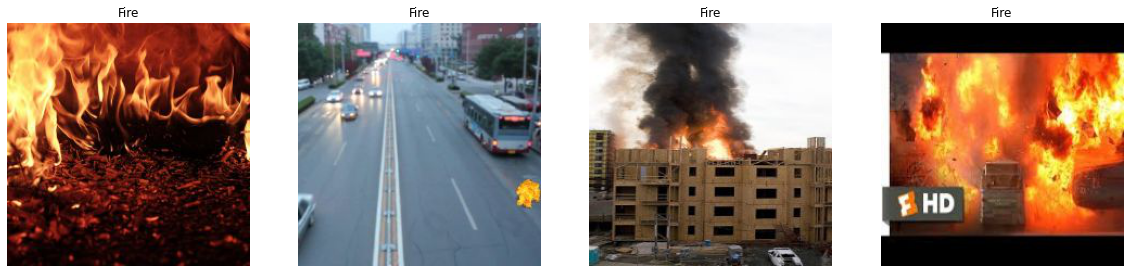

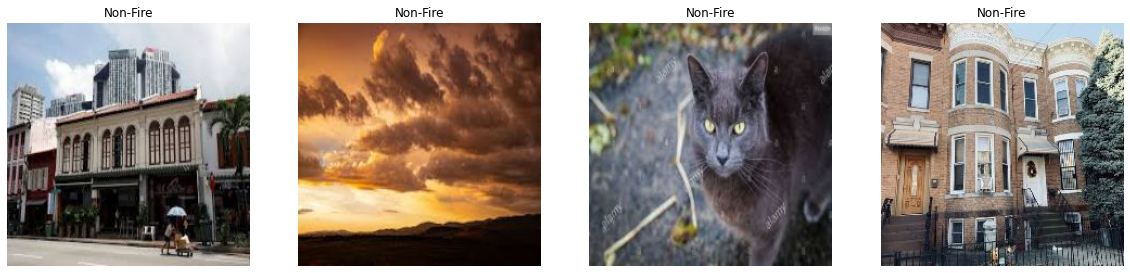

In [6]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(20, 20))

    filenames = os.listdir(path + 'Train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(path +'Train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

# Preprocessing

## Normalization

In [7]:
# Normalizing the pixel values for faster convergence

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Model

## Transfer learning

In [8]:
base_model = keras.applications.InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

87916544/87910968 [==============================] - 12s 0us/step


In [9]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.1), metrics=['accuracy'])

history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)

Epoch 1/32
94/94 [==============================] - 32s 339ms/step - loss: 0.6048 - accuracy: 0.9414 - val_loss: 2.8906 - val_accuracy: 0.7780
Epoch 2/32
94/94 [==============================] - 30s 315ms/step - loss: 0.4227 - accuracy: 0.9579 - val_loss: 0.3233 - val_accuracy: 0.9645
Epoch 3/32
94/94 [==============================] - 29s 314ms/step - loss: 0.4144 - accuracy: 0.9662 - val_loss: 0.4465 - val_accuracy: 0.9610
Epoch 4/32
94/94 [==============================] - 30s 316ms/step - loss: 0.2153 - accuracy: 0.9773 - val_loss: 1.6316 - val_accuracy: 0.8925
Epoch 5/32
94/94 [==============================] - 30s 321ms/step - loss: 0.2131 - accuracy: 0.9772 - val_loss: 3.1681 - val_accuracy: 0.8240
Epoch 6/32
94/94 [==============================] - 31s 325ms/step - loss: 0.7781 - accuracy: 0.9519 - val_loss: 3.5076 - val_accuracy: 0.8625
Epoch 7/32
94/94 [==============================] - 31s 331ms/step - loss: 0.2092 - accuracy: 0.9838 - val_loss: 1.2777 - val_accuracy: 0.9345

In [10]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.01), metrics=['accuracy'])

history1 = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)

Epoch 1/32
94/94 [==============================] - 32s 344ms/step - loss: 0.1214 - accuracy: 0.9832 - val_loss: 0.6774 - val_accuracy: 0.9315
Epoch 2/32
94/94 [==============================] - 32s 341ms/step - loss: 0.0859 - accuracy: 0.9855 - val_loss: 0.6161 - val_accuracy: 0.9345
Epoch 3/32
94/94 [==============================] - 32s 345ms/step - loss: 0.0678 - accuracy: 0.9893 - val_loss: 0.3464 - val_accuracy: 0.9600
Epoch 4/32
94/94 [==============================] - 32s 343ms/step - loss: 0.0502 - accuracy: 0.9903 - val_loss: 0.2878 - val_accuracy: 0.9590
Epoch 5/32
94/94 [==============================] - 32s 341ms/step - loss: 0.0341 - accuracy: 0.9923 - val_loss: 0.2821 - val_accuracy: 0.9590
Epoch 6/32
94/94 [==============================] - 32s 339ms/step - loss: 0.0313 - accuracy: 0.9932 - val_loss: 0.3318 - val_accuracy: 0.9560
Epoch 7/32
94/94 [==============================] - 32s 344ms/step - loss: 0.0258 - accuracy: 0.9935 - val_loss: 0.2684 - val_accuracy: 0.9600

In [11]:
model.evaluate(test_ds)

32/32 [==============================] - 8s 235ms/step - loss: 0.4545 - accuracy: 0.9405


[0.4544565975666046, 0.940500020980835]

# Plotting the metrics

In [12]:
def plot(history1, history2, variable1, variable2):
    # combining metrics from both trainings    
    var1_history = history1[variable1]
    var1_history.extend(history2[variable1])
    
    var2_history = history1[variable2]
    var2_history.extend(history2[variable2])
    
    # plotting them
    plt.plot(range(len(var1_history)), var1_history)
    plt.plot(range(len(var2_history)), var2_history)
    plt.legend([variable1, variable2])
    plt.title(variable1)

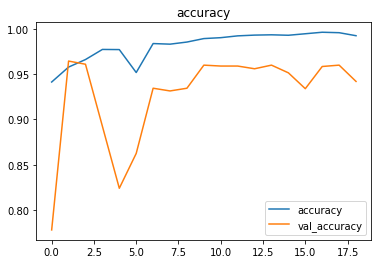

In [13]:
plot(history.history, history1.history, "accuracy", 'val_accuracy')

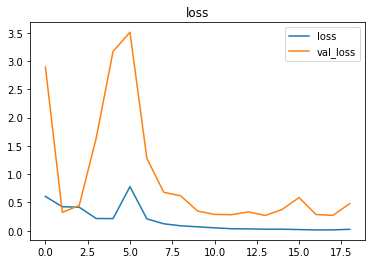

In [14]:
plot(history.history, history1.history, "loss", 'val_loss')

# Prediction

Predicted:  Non-Fire ( 1.0 --> 1 )
True:  Non-Fire


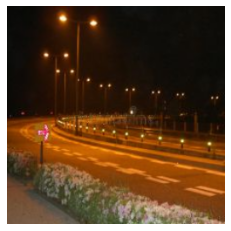

In [15]:
# pick random test data sample from one batch
x = random.randint(0, batch - 1)

for i in test_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (32, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))[0][0]    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = (output > 0.5).astype('int')
    print("Predicted: ", class_names[pred], '(', output, '-->', pred, ')')    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x][0].astype('int')])
    break

# deepC

In [16]:
model.save('fire.h5')

!deepCC fire.h5

[INFO]
Reading [keras model] 'fire.h5'
[SUCCESS]
Saved 'fire.onnx'
[INFO]
Reading [onnx model] 'fire.onnx'
[INFO]
Model info:
  ir_vesion : 5
  doc       : 
[WARNING]
[ONNX]: graph-node conv2d_2's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_5's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_6's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_8's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_11's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_7's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_9's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_10's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_12's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node conv2d_13's attribute auto_pad has no meaningful data.
[WARNING]